타이타닉 문제를 기반으로 핸즈온 머신러닝 챕터7장 내용을 정리한다.

***

# 개요. 앙상블 학습과 랜덤 포레스트

앙상블 학습의 아이디어는 '집단 지성'이다. 어렵고 복잡한 문제에 대해, 전문가 한 사람의 답 보다는 무작위로 선택된 수천명의 답이 더 나을때가 많다.
  
앙상블 학습의 원리도 이와 마찬가지이다. 여러 앙상블 방법들 중 하나는 훈련 데이터를 무작위로 각기 다른 서브셋으로 나눈다. 이 각각의 서브셋으로 훈련된 모델은 전체 훈련 데이터의 일부만을 학습하게 된다. 따라서 훈련 데이터 전체를 학습한 하나의 모델보다 훈련 데이터에 과소적합되어 개별 성능은 떨어진다. 그러나 이런 개별 모델들의 수가 많고 다양해지면 앙상블의 결과는 더 높은 성능을 발휘하게 된다.  
  
한 명의 전문가는 한 명의 불특정 개인보다 더 정확한 답을 말할 확률이 높다. 그러나 전문가가 언제나 정답을 말하는 것은 아니다. 어떤 문제의 경우는 전문가가 틀리고 불특정 개인이 정답을 말할 수 있다. 이러한 불특정 개인이 굉장히 많다면? 그 집단이 말한 답이 정답일 가능성이 높을 것이다. 앙상블 학습은 이러한 집단의 정답을 학습시키는 원리이다.
  
타이타닉 문제로 예를 들면 이렇다. 전체 training set을 학습 시킨 분류기(전문가)가 생존자 한명을 사망자로 잘못 분류했다고 하자. 그리고 우리에게 training set의 일부를 학습 시킨 100개의 또 다른 분류기들(집단)이 있다. 이 100개의 모델들 중에서 70개는 사망자로 잘못 분류된 해당 승객을 생존자로 분류했다. 그렇다면 앙상블의 예측 결과는 이를 생존자로 분류한다. '전문가' 분류기는 해당 승객에 대해 오답을 말했어도 앙상블은 더 나은 결과를 내놓는다. 물론 반대의 결과가 나타날수도 있다.  
  

1) **앙상블(ensemble)** : 여러개의 모델(예측기, 분류기) 집단을 앙상블이라 부른다. 무작위로 선택된 '집단'에 대응하는 개념이다.  
<br>
2) **앙상블 방법(ensemble method)** : 앙상블 학습 알고리즘을 말한다.  
<br>
3) **랜덤 포레스트(random forest)** : 결정 트리의 앙상블
{: .notice--info}

위 타이타닉 예시와 같이 앙상블 학습의 예측 알고리즘은 '다수결의 원칙'이다. 개별 모델들의 예측을 모두 구한 뒤 가장 많은 선택을 받은 클래스를 예측 결과로 제시한다.

***


# 7.1 투표 기반 분류기

앙상블 학습은 결국 다양한 분류기를 만들어내는 것이 핵심이다. 다양한 분류기를 만드는 방법 중 하나는 서로 다른 알고리즘을 가진 분류기를 만드는 것이다. 그림으로 표현하면 다음과 같다.  

***

![](https://github.com/romanticq/romanticq.github.io/blob/master/assets/images/handson-chap7/ensemble1.png?raw=true)

***

분류 알고리즘은 여러가지가 존재한다. 로지스틱회귀, SVM, 랜덤 포레스트 등 다양한 분류기에 하나의 훈련 데이터를 학습시킨다. 그리고 예측은 다수결로 진행한다. 각 모델들이 제시한 예측을 모아 가장 많은 투표를 받은 클래스를 예측 결과로 택한다.  

***

![](https://github.com/romanticq/romanticq.github.io/blob/master/assets/images/handson-chap7/ensemble2.png?raw=true)

***

투표 기반 분류기의 성능 확인을 위해 타이타닉 데이터를 학습시켜보자. 분류 문제이므로 성능 지표는 AUC를 이용한다.

***

## 7.1.1 데이터 로드 & 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

train_test_data = [train, test]

# Sex 전처리
sex_mapping = {"male":0, "female":1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

# SibSp & Parch 전처리
for dataset in train_test_data:
    # 가족수 = 형제자매 + 부모님 + 자녀 + 본인
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1
    
    # 가족수 > 1이면 동승자 있음
    dataset.loc[dataset['FamilySize'] > 1, 'IsAlone'] = 0
    
# Embarked 전처리
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

embarked_mapping = {'S':0, 'C':1, 'Q':2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)
    
# Name 전처리
for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract('([\w]+)\.', expand=False)

for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].apply(lambda x: 0 if x=="Mr" else 1 if x=="Miss" else 2 if x=="Mrs" else 3 if x=="Master" else 4)

# Age 결측치 제거
for dataset in train_test_data:
    dataset['Age'].fillna(dataset.groupby("Title")["Age"].transform("median"), inplace=True)
    
# Age min-max 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for dataset in train_test_data:
    array = dataset['Age'].values.reshape(-1,1) # 2D array로 변환
    scaler.fit(array) # 스케일링에 필요한 값(최소값, range 등) 계산
    dataset['AgeScale'] = pd.Series(scaler.transform(array).reshape(-1)) # 스케일링 후 series로 추가
    
# Fare 결측치 제거
for dataset in train_test_data:
    dataset["Fare"].fillna(dataset.groupby("Pclass")["Fare"].transform("median"), inplace=True)
    
# Fare 표준화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for dataset in train_test_data:
    array = dataset['Fare'].values.reshape(-1,1)
    scaler.fit(array)
    dataset['FareScale'] = pd.Series(scaler.transform(array).reshape(-1))
    
# 전처리가 끝난 특성들 제거
drop_column = ['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'FamilySize']

for dataset in train_test_data:
    dataset = dataset.drop(drop_column, axis=1, inplace=True)

In [2]:
train.head()

,PassengerId,Survived,Pclass,Sex,Embarked,IsAlone,Title,AgeScale,FareScale
0,1,0,3,0,0,0,0,0.271174,-0.502445
1,2,1,1,1,1,0,2,0.472229,0.786845
2,3,1,3,1,0,1,1,0.321438,-0.488854
3,4,1,1,1,0,0,2,0.434531,0.420730
4,5,0,3,0,0,1,0,0.434531,-0.486337


***

## 7.1.2 모델 훈련 및 평가

In [42]:
# 훈련을 위한 train, target 분할
drop_column2 = ['PassengerId', 'Survived']
train_data = train.drop(drop_column2, axis=1)
gender_submission = pd.read_csv('./gender_submission.csv')

# 테스트 셋
test_data = test.drop("PassengerId", axis=1)
test_target = gender_submission['Survived']

# 여러 분류기 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 모델 불러오기
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

# 투표 기반 분류기 셋팅
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rd', rnd_clf), ('svc', svm_clf)],
    voting = 'soft')

# 모델 훈련 및 평가
from sklearn.metrics import roc_auc_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(train_data, target)
    proba_score = clf.predict_proba(train_data)
    y_score = proba_score[:,1]
    print(clf.__class__.__name__, roc_auc_score(target, y_score))

LogisticRegression 0.8614466494104113
RandomForestClassifier 0.9967804301281437
SVC 0.8714169303039018
VotingClassifier 0.9685046709061664


기대했던 것과 달리 투표 기반 분류기의 성능이 가장 좋게 나오지 않았다. 원인은 다음 두 가지로 생각된다.

1) 분류기의 다양성 부족  
<br>
2) 분류기간 성능 격차가 너무 큼
{: .notice--info}

***

# 7.2 배깅(bagging)과 페이스팅(pasting)

7.1에서는 다양한 분류기의 생성 방법으로 다른 훈련 알고리즘을 사용했다. 또 다른 방법으로는 훈련 세트를 무작위로 여러개의 서브셋으로 나누어 분류기들을 각기 다르게 학습시키는 것이다. 훈련 세트의 분할(혹은 샘플링) 방식에 따라 두 가지로 나뉜다.

1) 배깅 : 훈련세트에서 중복을 허용하여 샘플링. `bootstrap aggregating`의 줄임말
<br>
2) 페이스팅 : 중복을 허용하지 않고 샘플링
{: .notice--info}

그림으로 표현하면 다음과 같다.

***

![](https://github.com/romanticq/romanticq.github.io/blob/master/assets/images/handson-chap7/bagging1.png?raw=true)

***

예측 알고리즘은 위에서 설명한 바와 같다. 분류의 경우 통계적 최빈값(다수결), 회귀의 경우 각 예측값의 평균을 계산한다.  

다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드이다.

In [47]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=4), n_estimators=500, max_samples=100,
    bootstrap=True, n_jobs=-1)
bag_clf.fit(train_data, target)
y_pred = bag_clf.predict(test_data)

각 매개변수의 의미는 다음과 같다.  

1) `n_estimators` : 모델의 개수  
<br>
2) `max_samples` :  샘플의 크기. 즉 샘플링을 통해 만든 하나의 훈련 서브셋의 원소 수
<br>
3) `bootstrap` : True이면 배깅, False이면 페이스팅에 해당한다.  
<br>
4) `n_jobs` : 훈련과 예측에 사용할 CPU 코어 수. 기본값은 1이며, -1로 설정하면 모든 코어를 사용한다.
{: .notice--info}

***

## 7.2.1 oob 평가

배깅은 중복을 허용하므로 여러번 샘플링 되는 샘플이 있는가 하면 전혀 샘플링 되지 않는 녀석도 있을 수 있다. 평균적으로 각 예측기마다 훈련 샘플의 63%만을 샘플링 한다. 이유는 다음과 같다.  
  
>훈련 세트의 크기를 $m$ 이라 하자. `n_estimators=500`이면 500개의 예측기가 각각 서로 다른 샘플링 데이터를 훈련하게 된다. `max_samples` 매개변수를 따로 설정하지 않았을 경우`샘플의 크기 = 훈련 세트의 크기`$= m$ 이다.  
>  
>$m$개의 샘플에서 무작위로 하나를 추출할 때 선택되지 않을 확률은 $1 - {1 \over m}$ 이다. 하나의 서브셋을 구성하기 위해서는 $m$개의 샘플이 필요하므로 $m$번 반복 후에도 선택되지 않을 확률은 $\left( 1-{1 \over m} \right)^m$이다. $m$이 큰 값을 가질 때 이 지수값은 $e^{-1}$이므로 샘플링될 확률은 $1-e^{-1}$인 약 63%가 된다.

선택되지 않은 훈련 샘플 37%를 `oob(out-of-bag) 샘플`이라 한다. oob 샘플은 예측기마다 모두 다르다.  
  
  
oob 샘플은 예측기 훈련에 이용되지 않는다. 따라서 별도의 검증세트를 사용할 필요 없이 oob 샘플을 통해 예측기를 평가할 수 있다. 사이킷런에서 모델을 훈련시킬 때 매개변수 `oob_score=True`로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행한다.

In [40]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=4), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(train_data, target)
proba_score = bag_clf.oob_decision_function_
y_score = proba_score[:,1]
roc_auc_score(target, y_score)

0.8558410294101982

# 7.3 랜덤 포레스트

랜덤 포레스트는 배깅 또는 페이스팅을 적용한 결정 트리의 앙상블을 말한다. `BaggingClassifier` 안에 결정트리를 집어넣어 만들 수도 있지만 사이킷런에서는 결정트리에 더욱 최적화된 `RandomForestClassifier`를 제공한다. oob 평가를 위해 만들었던 모델을 랜덤 포레스트 패키지로 바꿔보자.

In [50]:
# 배깅 + 결정트리
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=4), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

# 랜덤 포레스트
rnd_clf = RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1, oob_score=True)

하이퍼 파라미터는 결정트리와 대부분 공유한다.  

결정트리의 훈련 알고리즘은 비용함수를 최소화하기 위한 특성을 찾는 것이다. 이 특성을 찾기 위해 모든 특성을 비용함수에 대입하여 최적의 임계값을 계산한다. 그러나 랜덤 포레스트는 전체 특성을 조사하지 않고 무작위로 특성을 선택한다. 그리고 그 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 주입하여 모델을 훈련시킨다. 여기에 한 번 더 무작위성을 주입시킨 알고리즘이 엑스트라 트리이다.  

***

## 7.3.1 엑스트라 트리

결정트리, 랜덤 포레스트의 공통점은 결국 모든 노드마다 최적의 임계값을 구한다는 것이다. 그리고 이 작업은 트리 알고리즘에서 가장 많은 시간을 잡아먹는다.  
  
엑스트라 트리는 분할을 위해 무작위로 특성 후보를 선택한다. 여기까지는 랜덤 포레스트와 동일하다. 그러나 특성 후보를 선택하고 나서 최적의 임계값을 찾지 않는다. 무작위로 뽑힌 각 특성에 대해 랜덤한 임계값을 적용해 노드를 분할한다. 이러한 무작위성은 규제처럼 작용하여 과대적합을 예방할수도 있다. 

***

# 7.4 부스팅(boosting)

부스팅은 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법을 말한다. 배깅과의 공통점은 하나의 알고리즘으로 여러 예측기를 만든다는 것이다. 배깅은 여러개의 예측기가 독립적으로 학습한다. 병렬학습이라고 볼 수 있다. 그러나 부스팅은 직렬학습이다. 앞서 학습한 예측기의 결과가 다음 예측기의 결과에 영향을 주면서 점점 보완해나가는 방식이다.  

***

## 7.4.1 에이다부스트(AdaBoost : Adaptive boosting)

에이다부스트는 이전 모델이 과소적합했던 훈련 샘플의 가중치를 높여 다음 모델에 훈련하는 방식이다.

***

![](https://github.com/romanticq/romanticq.github.io/blob/master/assets/images/handson-chap7/boosting1.png?raw=true)

***

에이다부스트 분류기를 만든다고 하자. 첫 번째 분류기를 훈련시키고 예측을 만든다. 그 다음 잘못 분류된 훈련 샘플의 가중치를 제대로 분류된 샘플의 가중치보다 더 크게 만든다. 두 번째 분류기는 업데이트된 가중치를 사용하여 동일한 훈련 세트에서 훈련하고 예측을 만든다. 이 과정을 마지막 분류기까지 반복하는 것이다. 에이다부스트의 훈련 알고리즘은 다음과 같다.

***

### 7.4.1.1 에이다부스트 훈련 알고리즘

1) **가중치 초기화**
{: .notice--info}

훈련 세트의 크기를 $m$이라 할 때, 모든 샘플에 ${1 \over m}$의 가중치를 부여한다.  
  
2) **첫 번째 분류기 훈련**
{: .notice--info}

첫 번째 분류기에 훈련 세트를 학습시킨다.  
  
3) **에러율($r_j$) 계산**
{: .notice--info}

훈련이 끝나면 훈련 결과를 바탕으로 에러율($r_j$)을 계산한다. $j$번째 예측기에 대한 에러율 $r_j$의 식은 다음과 같다.

$$r_j = {\underset{\hat{y_j}^{(i)} \ne y^{(i)}}{\sum_{i=1}^{m} w^{(i)}} \over \sum_{i=1}^{m} w^{(i)}} $$

분모는 모든 샘플의 가중치 합이고 분자는 예측이 잘못된 샘플의 가중치 합이다.

4) **예측기 가중치($\alpha_j$) 계산**
{: .notice--info}

예측기의 가중치($\alpha_j$)를 계산한다. $j$번째 예측기의 가중치는 다음과 같다.

$$ \alpha_j = \eta \ln{1-r_j \over r_j} $$

여기서 $\eta$는 학습률 하이퍼파라미터로 기본값은 1이다.

> * 예측기의 정확도가 높은 경우  
> $r_j \to 0$ $\quad \Rightarrow \quad$  ${1-r_j \over r_j} \to \infty$ $\quad \Rightarrow \quad$ $\alpha_j \to \infty$  
> <br>
> * 예측기가 무작위 예측인 경우  
> $r_j \to {1 \over 2}$ $\quad \Rightarrow \quad$ ${1-r_j \over r_j} \to 1$ $\quad \Rightarrow \quad$ $\alpha_j \to 0$  
> <br>
> * 예측기가 무작위 예측보다 정확도가 낮은 경우  
> $r_j \to 1$ $\quad \Rightarrow \quad$ ${1-r_j \over r_j} \to 0$ $\quad \Rightarrow \quad$ $\alpha_j \to -\infty$

5) **샘플 가중치($w^{(i)}$) 업데이트**
{: .notice--info}

제대로 예측된 샘플의 가중치는 그대로 유지하고 잘못 예측된 샘플의 가중치를 업데이트한다. 규칙은 다음과 같다.  

$$ w^{(i)} \gets
\begin{cases}
w^{(i)} & \mbox{if} \quad \hat{y_j}^{(i)} = y^{(i)} \\
w^{(i)}\mbox{exp}(\alpha_j) & \mbox{if} \quad \hat{y_j}^{(i)} \ne y^{(i)}
\end{cases}
\quad \mbox{where} \quad i=1,2, \cdots, m
$$

예측기의 성능이 무작위 예측기보다 높다는 것만 보장된다면, 업데이트된 가중치는 반드시 기존 가중치보다 커진다. 이유는 다음과 같다.  

> $r_j < {1 \over 2}$ $\quad \Rightarrow \quad$ ${1-r_j \over r_j} > 1$ $\quad \Rightarrow \quad$ $\alpha_j > 0$
> $\quad \Rightarrow \quad$ $e^{\ \alpha_j} > 1$
  
6) **가중치($w^{(i)}$) 정규화**
{: .notice--info}

모든 샘플의 가중치를 각각 $\sum_{i=1}^{m} w^{(i)}$으로 나눈다. 이는 가중치의 총합이 1이 되게끔 만들기 위함이다.

***

### 7.4.1.2 에이다부스트 예측 알고리즘

타이타닉 문제를 예로 들면 다음과 같다.

1) 새로운 승객 데이터($x$)가 들어오면 에이다부스트를 이루고 있는 모든 분류기가 이 승객을 사망자 또는 생존자로 분류한다.  
<br>
2) 생존자로 분류한 분류기들의 가중치($\alpha_j$)를 모두 더해서 $\alpha_1$ 이라 한다.  
<br>
3) 사망자로 분류한 분류기들의 가중치를 모두 더해서 $\alpha_2$라 한다.  
<br>
4) 최종적으로 $x$는 $\alpha_1$이 더 크면 생존자, $\alpha_2$가 더 크면 사망자로 분류된다.
{: .notice--info}

다음은 깊이가 1(2개의 리프노드)인 결정트리 200개로 이루어진 에이다부스트를 훈련시킨 코드이다.

In [58]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)

ada_clf.fit(train_data, target)
proba_score = ada_clf.predict_proba(train_data)
y_score = proba_score[:,1]
roc_auc_score(target, y_score)

0.9045979399013624

## 7.4.2 그래디언트 부스팅(gradient boosting)

에이다부스트가 샘플들의 가중치를 수정했다면, 그래디언트 부스팅은 이전 예측기가 만든 잔여 오차(residual error)에 다음 예측기를 학습시킨다.

In [56]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

# 잡음이 들어간 데이터셋 학습
from sklearn.tree import DecisionTreeRegressor

reg1 = DecisionTreeRegressor(max_depth=2)
reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

첫 번째 트리에서 생긴 잔여 오차에 두 번째 회귀트리를 훈련시킨다.

In [57]:
y2 = y - reg1.predict(X).reshape(-1,1)
reg2 = DecisionTreeRegressor(max_depth=2)
reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델을 훈련시킨다.

In [58]:
y3 = y2 - reg2.predict(X).reshape(-1,1)
reg3 = DecisionTreeRegressor(max_depth=2)
reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

이 과정을 그림으로 표현하면 다음과 같다.

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Text(0, 0.5, '$y$')

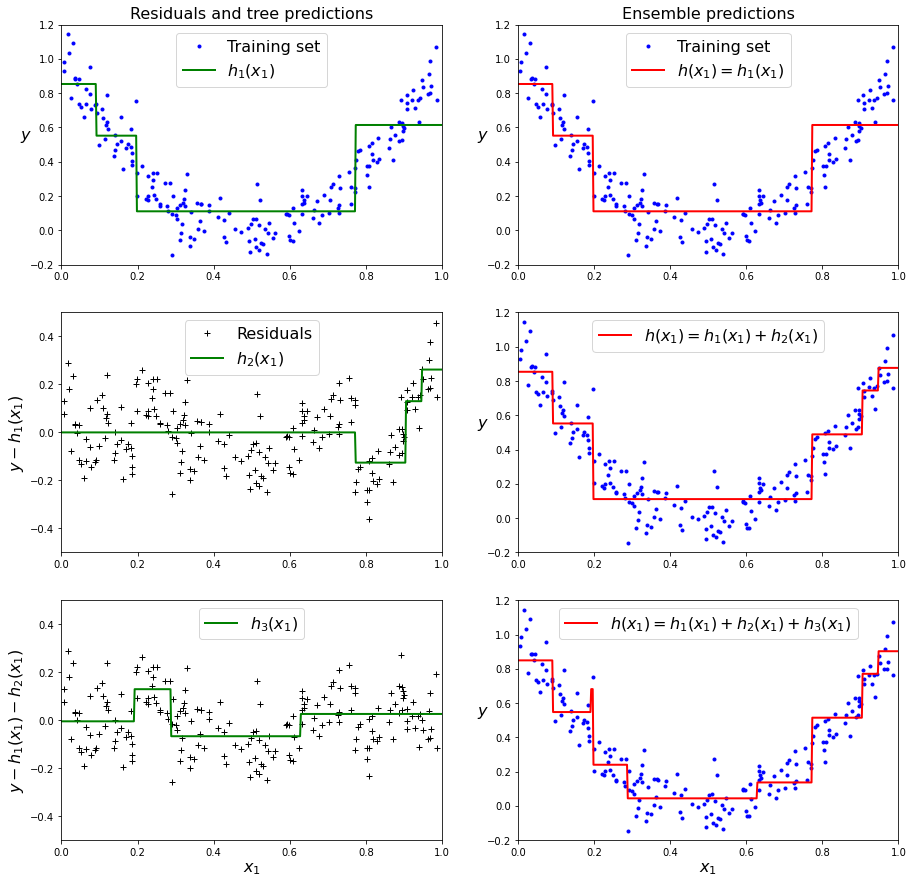

In [17]:
plt.figure(figsize=(15,15))

plt.subplot(321)
plot_predictions([reg1], X, y, axes=[0, 1, -0.2, 1.2], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([reg1], X, y, axes=[0, 1, -0.2, 1.2], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([reg2], X, y2, axes=[0, 1, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([reg1, reg2], X, y, axes=[0, 1, -0.2, 1.2], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([reg3], X, y3, axes=[0, 1, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([reg1, reg2, reg3], X, y, axes=[0, 1, -0.2, 1.2], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

위처럼 결정트리에 그래디언트 부스팅을 적용한 회귀 모델을 `그래디언트 부스티드 회귀 트리(GBRT)`라 한다. 사이킷런에서 패키지를 제공하므로 아래와 같이 간단하게 사용할 수 있다.

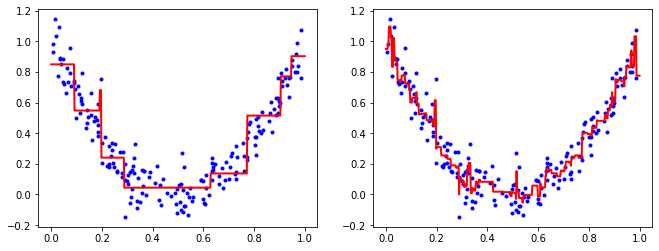

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)
gbrt.fit(X,y.reshape(-1))

gbrt2 = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1)
gbrt2.fit(X,y.reshape(-1))

x=np.linspace(0,1,500).reshape(-1,1)
y_pred = gbrt.predict(x)
y_pred2 = gbrt2.predict(x)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(X,y,'b.')
plt.plot(x,y_pred, 'r-', linewidth=2)

plt.subplot(122)
plt.plot(X,y,'b.')
plt.plot(x,y_pred2, 'r-', linewidth=2)

plt.show()